# STAPL-3D segmentation demo

This notebook demonstrates the core components of the STAPL-3D segmentation pipeline: **blockwise segmentation** and **zipping**.

If you did not follow the STAPL-3D README: please find STAPL-3D and the installation instructions [here](https://github.com/RiosGroup/STAPL3D) before doing this demo.

Because STAPL-3D is all about big datafiles, we provide small cutouts and precomputed summary data that will be downloaded while progressing through the notebook.

Let's start with some general settings and imports.

In [1]:
# Qt gui for napari viewer
%gui qt

# Show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Imports.
import os
import yaml
import urllib.request
from pprint import pprint

# Yaml printing function.
def yprint(ydict):
    """Print dictionary in yaml formatting."""
    print(yaml.dump(ydict, default_flow_style=False))


First, define where you want the data to be downloaded by changing *projectdir*; default is the current demo directory. The name of the dataset is *'HFK16w'* (for Human Fetal Kidney - 16 weeks). We create a directory for the dataset and jump to it.

In [2]:
projectdir = '.'
dataset = 'HFK16w'

datadir = os.path.join(projectdir, dataset)

os.makedirs(datadir, exist_ok=True)
os.chdir(datadir)
f'working in directory: {os.path.abspath(".")}'


'working in directory: /Users/michielkleinnijenhuis/demos_clean/HFK16w'

We define STAPL3D parameters preferably using a [yaml](https://yaml.org) parameter file. It has a simple structure and can be parsed in Python and `bash`. We will download the example, read it into a dictionary structure, list all entries and show the entry that contains information on the default directory structure for STAPL3D. 

In [3]:
parameter_file = f'{dataset}.yml'

# Download the yml-file.
if not os.path.exists(parameter_file):
    url = 'https://surfdrive.surf.nl/files/index.php/s/Ubx9wVon5CIuIzo/download'
    urllib.request.urlretrieve(url, parameter_file)

# Load parameter file.
with open(parameter_file, 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

# List all entries.
cfg.keys()

# Inspect directory tree.
yml_entry = 'dirtree'
yprint(cfg[yml_entry])  # in yaml format
pprint(cfg[yml_entry])  # as a dictionary


dict_keys(['submit_defaults', 'dirtree', 'dataset', 'shading', 'stitching', 'mask', 'biasfield', 'blocks', 'splitter', 'membrane_enhancement', 'segmentation', 'subsegmentation', 'merger'])

datadir:
  biasfield: biasfield
  blocks: blocks
  channels: channels
  jobfiles: jobfiles
  mask: null
  profiling: profiling
  shading: shading
  stacks: stacks
  stitching: stitching

{'datadir': {'biasfield': 'biasfield',
             'blocks': 'blocks',
             'channels': 'channels',
             'jobfiles': 'jobfiles',
             'mask': None,
             'profiling': 'profiling',
             'shading': 'shading',
             'stacks': 'stacks',
             'stitching': 'stitching'}}


## Dataset

We provided a preprocessed data cutout in the Imaris v5.5 file format. which is an hdf5 file with 5 dimensions (a free [Imaris Viewer](https://imaris.oxinst.com/imaris-viewer) is available; and the file format can be inspected with [HDFview](https://www.hdfgroup.org/downloads/hdfview/) or with `h5ls` or `h5py`.

We download the file and name it according to the default STAPL-3D pipeline conventions.

In [4]:
ims_filepath = f'{dataset}_shading_stitching.ims'  # f'{dataset}_shading_stitching_biasfield.ims'

# Download the ims-file.
if not os.path.exists(ims_filepath):
    url = 'https://surfdrive.surf.nl/files/index.php/s/NxWhUWuLQBHPMGV/download'
    urllib.request.urlretrieve(url, ims_filepath)


We use the STAPL-3D Image class to load this file and inspect it's properties. We'll also save the dimensions, the Z-dimension and the number of channels in convenience variables `dims`, `Z` and `C`.


In [5]:
# Print image properties.
from stapl3d import Image
image_in = ims_filepath
im = Image(image_in)
im.load(load_data=False)
props = im.get_props()
im.close()
pprint(props)

# Convinience variables.
dims = im.dims
Z = im.dims[im.axlab.index('z')]
C = im.dims[im.axlab.index('c')]


{'axlab': 'zyxct',
 'chunks': [8, 256, 256, 1, 1],
 'dtype': dtype('uint16'),
 'elsize': [1.2048018867924528, 0.33210937500000043, 0.33210440340909086, 1, 1],
 'protective': False,
 'shape': [106, 1408, 1408, 8, 1],
 'slices': [slice(0, 106, 1),
            slice(0, 1408, 1),
            slice(0, 1408, 1),
            slice(0, 8, 1),
            slice(0, 1, 1)]}


In processing the full dataset, this cutout of **106 x 1408 x 1408 x 8** would equate to a single datablock, but for this demo we will further subdivide this block to demonstrate the pipeline.

## Parallelization

We have specified the shape of the processing blocks in the parameter file. Usually we would opt for a blocksize of ~100-200 million voxels; now we chose a blocksize in xy of 176 for 64 blocks of ~6M voxels. We keep the margin similar to what we set for big datasets as reducing it may hinder adequate analysis.

In [6]:
yprint(cfg['blocks']['blockinfo'])


blockmargin:
  x: 64
  y: 64
blocksize:
  x: 176
  y: 176
inputs:
  data: HFK16w_shading_stitching.ims



The full anatomy of the blocked processing can now be loaded through the blocker object.


In [7]:
from stapl3d import blocks
block3r = blocks.Block3r(image_in, parameter_file, prefix=dataset)
print(block3r)


Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
blocks:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: blocks
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs: {}
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 0
      blocks: []



In initializing the *block3r* object, the sizes for the zyxct-dimensions were read from the input data and the dimensions that were specified in the configuration file for blocksize were substituted to determine the 5D-blocksize. 

For segmentation, we use a weighted sum of the membrane channels (ch3, ch5, ch6, ch7). The weights [0.5, 0.5, 1.0, 1.0] work well for this data. We set the name and internal .h5 path to 'memb/mean'.
We have specified this in the parameter file HFK16w.yml:

In [8]:
yprint(cfg['splitter']['split']['volumes'])


chan/ch00:
  idxs:
  - 0
  weights:
  - 1.0
mean:
  idxs:
  - 0
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7
  weights:
  - 1.0
  - 1.0
  - 1.0
  - 1.0
  - 1.0
  - 1.0
  - 1.0
  - 1.0
memb/mean:
  idxs:
  - 3
  - 5
  - 6
  - 7
  weights:
  - 0.5
  - 0.5
  - 1.0
  - 1.0



The above indicates that, in addition to the membrane sum, we generate a mean over all channels (used for generating masks). Importantly, we specify that we want to output channel 0 (DAPI), because we will use it to create a nuclear mask. 

Now we are ready to call the function that computes the membrane mean, and splits the data into blocks at the same time.

In [9]:
splitt3r = blocks.Splitt3r(image_in, parameter_file, prefix=dataset)
splitt3r.run()


2021-06-03 12:45:22 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:45:22 [MainThread  ] [INFO ]  Parameters: 
splitter:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: splitter
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 1

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "split":
   ... using {'data': 'HFK16w_shading_stitching.ims', 'bias': ''}.
Running splitter:blockinfo
Running splitter:split


Datablocks are written to the *HFK16w/blocks/* directory and are postfixed by the numeric ID of the block HFK16w/blocks/HFK16w_**B{b:05}**.h5.

These are some of the files that were generated:

In [10]:
from glob import glob

filelist = glob(os.path.join(os.path.abspath('.'), 'blocks', f'{dataset}_*.h5'))
filelist.sort()

f'Number of blocks: {len(filelist)}'
filelist[:5]


'Number of blocks: 64'

['/Users/michielkleinnijenhuis/demos_clean/HFK16w/blocks/HFK16w_blocks_B00000.h5',
 '/Users/michielkleinnijenhuis/demos_clean/HFK16w/blocks/HFK16w_blocks_B00001.h5',
 '/Users/michielkleinnijenhuis/demos_clean/HFK16w/blocks/HFK16w_blocks_B00002.h5',
 '/Users/michielkleinnijenhuis/demos_clean/HFK16w/blocks/HFK16w_blocks_B00003.h5',
 '/Users/michielkleinnijenhuis/demos_clean/HFK16w/blocks/HFK16w_blocks_B00004.h5']

The resulting hdf5 files have three datasets named according to 'outputvolumes' entries in the cfg['splitter']['split'] specification, i.e. they have the following internal file structure:
- <...>.h5/mean
- <...>.h5/chan/ch00
- <...>.h5/memb/mean

It can be inspected and listed with the help of h5py:

In [11]:
import h5py

def extract_node_names(name, node):
    if isinstance(node, h5py.Dataset):
        nodes.append(name)
    return None

nodes = []
with h5py.File(filelist[0], 'r') as f:
    f.visititems(extract_node_names)
    pprint({'dataset names': nodes})
    idx = 0
    print(f'dataset {nodes[idx]} properties: ', f[nodes[idx]])
    print(f'dataset {nodes[idx]} resolution: ', f[nodes[idx]].attrs['element_size_um'])
    print(f'dataset {nodes[idx]} axes labels: ', f[nodes[idx]].attrs['DIMENSION_LABELS'])


{'dataset names': ['chan/ch00',
                   'chan/ch00_opened',
                   'chan/ch00_shifted',
                   'mask',
                   'mean',
                   'memb/ACME_planarity',
                   'memb/ACME_preprocess',
                   'memb/mask',
                   'memb/mean',
                   'memb/planarity',
                   'memb/prep',
                   'memb/preprocess',
                   'nucl/mask',
                   'nucl/prep',
                   'nucl/prep_mask_ero',
                   'prep',
                   'segm/labels',
                   'segm/labels_csol',
                   'segm/labels_edt',
                   'segm/labels_edt_ws0',
                   'segm/labels_full',
                   'segm/labels_memb',
                   'segm/labels_nucl',
                   'segm/labels_raw',
                   'segm/labels_zipmask',
                   'segm/peaks',
                   'segm/seeds_mask',
                   'segm/s

Naturally, we also need to visually inspect the resulting averaged volumes. We can use the napari viewer method provided in the *splitt3r* object. We limit to the first 42 blocks and pick the mean membrane channel for demonstration. 

In [12]:
idxs = list(range(42))  # block indices
images = ['memb/mean']  # 'chan/ch00'
viewer_settings = {
    'title': 'STAPL3D splitt3r demo',
    'crosshairs': [int(splitt3r.fullsize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clim': [0, 5000],
}

splitt3r.view_blocks(block_idxs=idxs, images=images, settings=viewer_settings)


To get a grip on how the dataset is layed out in blocks, we can alternate the colormaps of the blocks.

In [13]:
# Alternate colormaps.
cmaps = ['cyan', 'magenta', 'yellow']
for i, lay in enumerate(splitt3r.viewer.layers):
    lay.colormap = cmaps[i % len(cmaps)]
lay.colormap = 'gray'


## Membrane enhancement

Before segmentation, we perform membrane enhancement.

For the demo we do not want to be dependent on the third-party [ACME](https://wiki.med.harvard.edu/SysBio/Megason/ACME) software and provide the output that otherwise results from the ACME procedure. We split it into blocks, and write it as separate datasets in the same files as the channel data.

Alternatively, if you have ACME installed and want to run it, set an `ACME` path environment variable or point `ACMEdir` to the directory with the binaries.

In [14]:
max_workers = 5  # NB: ACME is memory-intensive

from stapl3d.segmentation import enhance
enhanc3r = enhance.Enhanc3r(image_in, parameter_file, prefix=dataset, max_workers=max_workers)
enhanc3r.ACMEdir = os.environ.get('ACME')

if enhanc3r.ACMEdir:

    # Perform membrane enhancement.
    enhanc3r.run()

else:

    # Download precomputed membrane enhancement.
    acme_filepath = f'{dataset}_shading_stitching_ACME.h5'
    if not os.path.exists(acme_filepath):
        url = 'https://surfdrive.surf.nl/files/index.php/s/oQcxIocFBkaXwJe/download'
        urllib.request.urlretrieve(url, acme_filepath)

    # Split into blocks
    from stapl3d import blocks
    for ids in ['memb/preprocess', 'memb/planarity']:
        im_in = f'{acme_filepath}/{ids}'
        splitt3r = blocks.Splitt3r(im_in, parameter_file, prefix=dataset, step_id='')
        splitt3r.inputpaths['split']['data'] = im_in
        splitt3r.volumes = {ids: {'idxs': [0], 'weights': [1.0]}}
        splitt3r.run()


2021-06-03 12:46:13 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:46:13 [MainThread  ] [INFO ]  Parameters: 
splitter:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: splitter
      image_in: HFK16w_shading_stitching_ACME.h5/memb/preprocess
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14


Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "split":
   ... using {'data': 'HFK16w_shading_stitching.ims', 'bias': ''}.
Running splitter:blockinfo
Running splitter:split


2021-06-03 12:46:20 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:46:20 [MainThread  ] [INFO ]  Parameters: 
splitter:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: splitter
      image_in: HFK16w_shading_stitching_ACME.h5/memb/planarity
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
 

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "split":
   ... using {'data': 'HFK16w_shading_stitching.ims', 'bias': ''}.
Running splitter:blockinfo
Running splitter:split


We vizualize the membrane-enhanced volume with napari.

In [15]:
# Initialize viewer.
idxs = list(range(42))  # block indices
images = ['memb/planarity']
viewer_settings = {
    'title': 'STAPL3D enhanc3r demo',
    'crosshairs': [int(enhanc3r.blocksize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clim': [0, 0.05],
}

enhanc3r.view_blocks(block_idxs=idxs, images=images, settings=viewer_settings)


## Segmentation

The segmentation is parallelized over the blocks we just created. Each of the 64 files is processed seperately.
The segmentation routine is associated with a fair amount of steps and parameters. This list all the parameters specified in the yml-file.

In [16]:
yprint(cfg['segmentation']['estimate'])  # TODO: need to preserve order of print


combine_masks:
  ids_memb: memb/mask
  ids_nucl: nucl/mask
  ods_mask: segm/seeds_mask
  opening_footprint:
  - 3
  - 7
  - 7
filter:
  ids_labels: segm/labels_raw
  ids_mask: prep
  max_size: 10000
  ods_labels: segm/labels
  postfix: _dset
mask_dset:
  ids_image: prep
  ods_mask: mask
  threshold: 1000.0
mask_memb:
  ids_image: memb/planarity
  ods_mask: memb/mask
  threshold: 0.0014
mask_nucl:
  erode:
    disk: 5
    postfix: _mask_ero
  ids_image: nucl/prep
  ods_mask: nucl/mask
  sauvola:
    absmin: 1000.0
    fill: true
    k: 0.2
    threshold: 5000.0
    window_size:
    - 19
    - 75
    - 75
prep_dset:
  filter:
    inplane: true
    sigma: 50.0
    type: gaussian
  ids_image: mean
  ods_image: prep
prep_memb:
  filter:
    inplane: true
    sigma: 8
    type: median
  ids_image: memb/mean
  ods_image: memb/prep
prep_nucl:
  filter:
    inplane: true
    sigma: 1.0
    type: median
  ids_image: chan/ch00
  ods_image: nucl/prep
  opening:
    postfix: _opened
    selem: null

The blocks will processed in order according to the steps defined in the parameter file. Operations are listed below and step names have to be prefixed with these keywords.
- *prep*: filtering of volumes
- *mask*: compartment mask creation
- *combine*: mask combination
- *seed*: seed generation
- *segment*: watershed segmentation
- *filter*: size filtering and label masking

For your own data, it is advised to start with tuning the following parameters to optimize segmentation:
- mask_memb : threshold
- mask_nucl : sauvola : window_size
- mask_nucl : sauvola : threshold
- mask_nucl : sauvola : absmin
- seeds : peaks : window
- seeds : peaks : window
- segment : watershed : compactness
- prep_memb : filter : sigma
  

Next we calculate the segments for each block. Segmentation time of single block is in the minutes-range. The 106 x 240 x 240 blocksize (including the margin) will take ~1GB of memory per process. Please set the number of processes so that you will stay within RAM. `max_workers = 8` would be a fairly safe bet for modern systems; `max_workers = 0` results in using all available processors.

In [17]:
from stapl3d.segmentation import segment

max_workers = 0

segment3r = segment.Segment3r(image_in, parameter_file, prefix=dataset, max_workers=max_workers)
segment3r.run()


2021-06-03 12:46:51 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:46:51 [MainThread  ] [INFO ]  Parameters: 
segmentation:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: segmentation
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
 

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running segmentation:blockinfo
Running segmentation:estimate


Report pages (pdf) have been written to the *HFK16w/blocks/* directory. Let's look at one of them:

2021-06-03 12:57:42 [MainThread  ] [WARNI]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-06-03 12:57:42 [MainThread  ] [WARNI]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-06-03 12:57:42 [MainThread  ] [WARNI]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


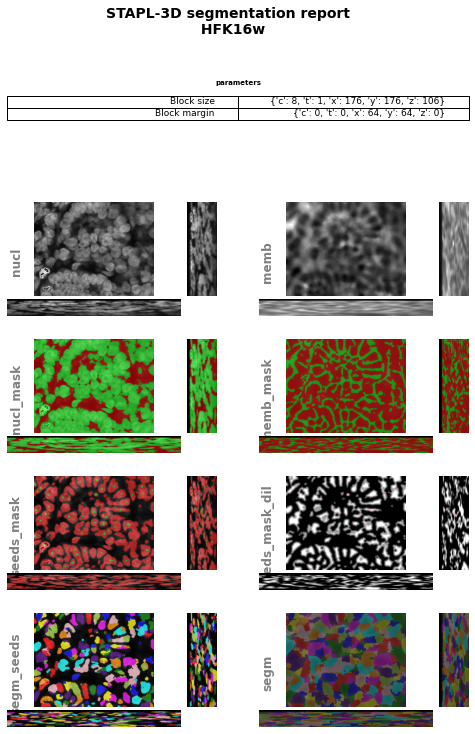

In [18]:
block_idx = 1
# Get the outputpaths of the 'estimate' method for a block.
_, opaths = segment3r.fill_paths('estimate', reps={'b': block_idx})
# (Re)generate the report from the data and plot inline.
segment3r.report(outputpath=None, ioff=False, outputs=opaths)


From top to bottom, images are show for:
 - the smoothed DAPI and mean membrane channels
 - the nuclear mask and the membrane mask
 - the combined mask with detected peaks and overlaid on the distance transform image
 - the first and the final watershed results


We use the 'labels' argument to visualize masks and labels in napari. First, this overlays the membrane mask with the planarity volume for the top row of blocks.

In [19]:
idxs = list(range(8))  # block indices
images = ['memb/planarity']
labels = ['nucl/mask']

viewer_settings = {
    'title': 'STAPL3D segment3r demo',
    'crosshairs': [int(segment3r.blocksize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clim': [0, 0.05],
}

segment3r.view(input=idxs, images=images, labels=labels, settings=viewer_settings)


Finally, we look at the extracted segments for the block we view as a pdf report.

In [20]:
images = ['nucl/prep']
labels = ['segm/labels']

viewer_settings = {
    'title': 'STAPL3D segment3r demo',
    'crosshairs': [int(segment3r.blocksize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clims': [0, 10000],
}

segment3r.view(input=block_idx, images=images, labels=labels, settings=viewer_settings)


# zipping

Having parallelized the segmentation process for increased analysis speed and reduced memory footprint, the need arises to reassemble the blocks into a final combined segmentation volume without seams at the block boundaries. These seams are a consequence of trivial parallelization in processing the individual blocks (i.e. without communication between the processes). They manifest through partial cells lying on the block boundaries that have been assigned different labels in different blocks. Importantly, these doubly segmented cells may not perfectly match up over the boundary.

This can be demonstrated by loading the segmentation of the top two rows of blocks:

In [21]:
segment3r.view(input=list(range(16)), images=images, labels=labels, settings=viewer_settings)


These block-boundary-segments need to be resegmented in order to complete the accurate segmentation of the full dataset. We refer to this correct reassembly of the datablocks as ‘zipping’. In short, it consists of identifying the segments lying on the boundaries, removing them, and resegmenting that space. We aimed to design the procedure such that it requires minimal computational resources and expertise (fast, with a low memory footprint, and without the need for communication between processes).

There is a one-liner for computing all the steps in the zip:
```
zipp3r.run()
```
which combines these three steps:
```
zipp3r.relabel()
zipp3r.copyblocks()
zipp3r.estimate()
```

For this demo, we will be much more verbose to illustrate the zipping process. 


We first perform a sequential relabeling of all the blocks to make each label unique.
We copy the relabeled blocks to new datasets in the same file for writing the zip-results in-place.

In [22]:
from stapl3d.segmentation import zipping

zipp3r = zipping.Zipp3r(image_in, parameter_file, prefix=dataset)

zipp3r.relabel()
zipp3r.copyblocks()


2021-06-03 12:57:53 [MainThread  ] [INFO ]  Running step "relabel" over 64 jobs using 16 workers
2021-06-03 12:57:53 [MainThread  ] [INFO ]  Parameters: 
zipping:
  relabel:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: zipping
      image_in: HFK16w_shading_stitching.ims
      inputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
        maxlabelfile: blocks/HFK16w_blocks_maxlabels_relabel.txt
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
      - 17
      -

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.


2021-06-03 12:58:03 [MainThread  ] [INFO ]  Running step "copyblocks" over 64 jobs using 16 workers
2021-06-03 12:58:03 [MainThread  ] [INFO ]  Parameters: 
zipping:
  copyblocks:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: zipping
      image_in: HFK16w_shading_stitching.ims
      inputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
        maxlabelfile: blocks/HFK16w_blocks_maxlabels_copyblocks.txt
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
      - 1

We define a convenience function that merges datablocks into a single volume and returns a single z-plane for display.

In [23]:
from stapl3d import blocks

import matplotlib as mpl
import matplotlib.pyplot as plt

volumes = {
    'memb/mean': {'format': 'h5', 'suffix': None},
    'segm/labels': {'format': 'h5', 'suffix': None, 'is_labelimage': True},
    'segm/labels_zip': {'format': 'h5', 'suffix': None, 'is_labelimage': True},
    'segm/labels_zipmask': {'format': 'h5', 'suffix': None},
}
merg3r = blocks.Merg3r(image_in, parameter_file, prefix=dataset)
merg3r.volumes = [{ids: vol} for ids, vol in volumes.items()]
merg3r._init_paths_merger()


def merge_and_slice_dset(merg3r, ids, slc=20):
    """Merge volume and return sliced data."""

    # Run the block merge.
    merg3r.run()

    # Get a slice of the merged data.
    _, opaths = merg3r.fill_paths('merge')
    im = Image(opaths[ids])
    im.load()
    im.slices[0] = slice(slc, slc + 1, 1)
    data = im.slice_dataset()
    im.close()

    return data


Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.


For plotting labels, we define a label shuffling function.

In [24]:
import numpy as np
from skimage.segmentation import relabel_sequential
from random import shuffle
from skimage.color import label2rgb

def shuffle_labels(labels):
    """Shuffle labels in a volume."""

    labels = relabel_sequential(labels)[0]
    ulabels = np.unique(labels[:])[1:]
    relabeled = [l for l in range(0, len(ulabels))]
    shuffle(relabeled)
    labels = np.array([0] + relabeled)[labels]

    return labels


Let's check with the membrane mean blocks. This should output an image of 1408 x 1408.

In [25]:
ids = 'memb/mean'
merg3r.volumes = [{ids: volumes[ids]}]
merg3r._init_paths_merger()
img = merge_and_slice_dset(merg3r, ids)


2021-06-03 12:58:10 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:58:10 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running merger:blockinfo
Running merger:merge


2021-06-03 12:58:48 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 12:58:48 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        memb/mean: HFK16w_memb-mean.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess


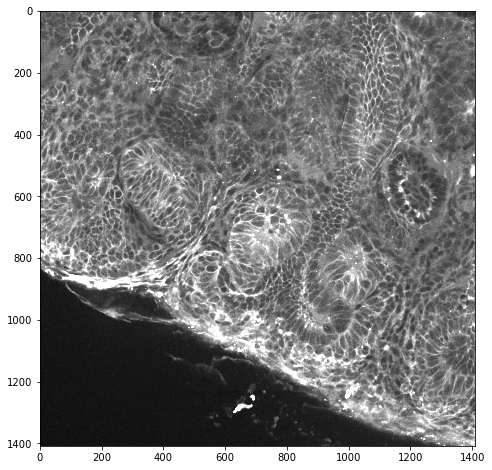

In [26]:
f = plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray', vmax=5000)
plt.show()


In the same way, we can show the labels with the seams before zipping.

In [27]:
ids = 'segm/labels_zip'
merg3r.volumes = [{ids: volumes[ids]}]
merg3r._init_paths_merger()
labels = shuffle_labels(merge_and_slice_dset(merg3r, ids))


2021-06-03 12:58:50 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 12:58:50 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running merger:blockinfo
Running merger:merge


2021-06-03 12:59:04 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 12:59:04 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess


<ipython-input-28-1d0aae9f541b>:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(label2rgb(labels))


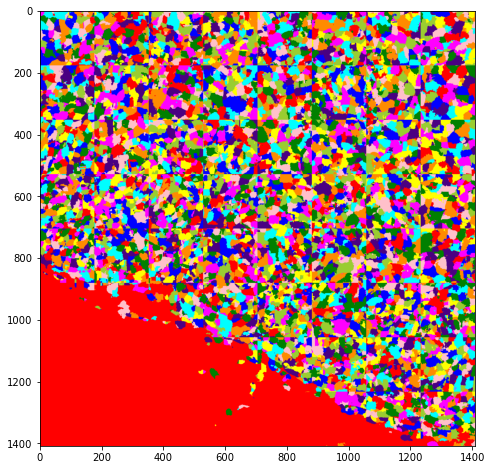

In [28]:
f = plt.figure(figsize=(8, 8))
plt.imshow(label2rgb(labels))
plt.show()


Next we set up the zipping estimation.

In [29]:
step_id = 'estimate'

# write maxlabels to file
outputs = zipp3r._prep_paths(zipp3r.outputpaths[step_id])
maxlabelfile = outputs['maxlabelfile']
kwargs = {}
arglist = zipp3r._prep_step(step_id, kwargs)
filepaths = zipp3r._get_filepaths(arglist)
zipping.get_maxlabels_from_attribute(
    filepaths,
    zipp3r.ids_labels,
    maxlabelfile,
)


2021-06-03 12:59:07 [MainThread  ] [INFO ]  Running step "estimate" over 64 jobs using 16 workers
2021-06-03 12:59:07 [MainThread  ] [INFO ]  Parameters: 
zipping:
  estimate:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: zipping
      image_in: HFK16w_shading_stitching.ims
      inputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
        maxlabelfile: blocks/HFK16w_blocks_maxlabels_estimate.txt
        report: blocks/HFK16w_blocks_B{b:05d}.h5.pdf
        stem: blocks/HFK16w_blocks
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
    

[1637,
 2181,
 2257,
 2191,
 2049,
 1988,
 1681,
 1227,
 2123,
 2544,
 2686,
 2510,
 2352,
 2547,
 2346,
 1405,
 2525,
 2992,
 2599,
 2147,
 2263,
 2510,
 2382,
 1505,
 3279,
 3920,
 3175,
 2813,
 2819,
 2741,
 2444,
 1828,
 3190,
 3921,
 3810,
 3648,
 3622,
 3301,
 2772,
 1993,
 1540,
 2569,
 3493,
 3911,
 3860,
 3537,
 3245,
 2430,
 82,
 660,
 1695,
 2741,
 3369,
 3575,
 3691,
 2928,
 0,
 2,
 124,
 717,
 1747,
 2542,
 2791,
 2241]

In the zipping procedure, we employ an order such that no blocks are handled concurrently. First, blocks with overlap in the Y-dimension are processed (odd and even zip-lines separately); then X-ziplines; then the corners where four datablocks overlap are resegmented. For demo purpose, we keep track of the output for each step and store it in `imgs`.

In [30]:
import numpy as np

imgs = []

# Initialize arguments
args = [filepaths, 0, [-1, -1, -1], maxlabelfile]

# Resegment zip-lines in 4 groups:
# horizontal/even, horizontal/odd, vertical/even, vertical/odd zip-lines.
for axis, n_seams in zip([1, 2], zipp3r.seamgrid.shape):
    n_proc = min(zipp3r._n_workers, int(np.ceil(n_seams / 2)))
    for offset in [0, 1]:
        zipp3r.compute_zip_step(
            args, axis=axis,
            starts=[offset, 0], stops=[n_seams, 1], steps=[2, 2],
            n_proc=n_proc,
        )
        zipping.get_maxlabels_from_attribute(
            filepaths,
            zipp3r.ods_labels,
            maxlabelfile,
        )
        imgs.append(merge_and_slice_dset(merg3r, 'segm/labels_zip'))

# Resegment zip-quads in 4 groups:
# even/even, even/odd, odd/even, odd/odd zip-line intersections
for start_y in [0, 1]:
    for start_x in [0, 1]:
        stops = list(zipp3r.seamgrid.shape)
        zipp3r.compute_zip_step(
            args, axis=0,
            starts=[start_y, start_x], stops=stops, steps=[2, 2],
            n_proc=zipp3r._n_workers,
        )
        zipping.get_maxlabels_from_attribute(
            filepaths,
            zipp3r.ods_labels,
            maxlabelfile,
        )
        imgs.append(merge_and_slice_dset(merg3r, 'segm/labels_zip'))


Submitting   4 jobs over   4 processes


[17313,
 19842,
 22535,
 25044,
 27393,
 29943,
 32291,
 33702,
 17334,
 19878,
 22564,
 25074,
 27426,
 29973,
 32319,
 33724,
 205182,
 206752,
 207985,
 208907,
 209882,
 210919,
 211921,
 212616,
 205182,
 206752,
 207985,
 208907,
 209882,
 210919,
 211921,
 212616,
 405126,
 406684,
 408406,
 410103,
 411786,
 413303,
 414578,
 415451,
 405126,
 406684,
 408406,
 410103,
 411786,
 413303,
 414578,
 415451,
 126590,
 127250,
 604037,
 604657,
 605896,
 607421,
 609068,
 610374,
 145249,
 145251,
 604037,
 604657,
 605896,
 607421,
 609068,
 610374]

2021-06-03 13:00:37 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:00:37 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:00:54 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:00:54 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting   3 jobs over   4 processes


[17313,
 19842,
 22535,
 25044,
 27393,
 29943,
 32291,
 33702,
 711378,
 712450,
 713542,
 714560,
 715571,
 716694,
 717758,
 718394,
 711378,
 712450,
 713542,
 714560,
 715571,
 716694,
 717758,
 718394,
 911971,
 913804,
 915376,
 916925,
 918445,
 919810,
 920985,
 921915,
 911971,
 913804,
 915376,
 916925,
 918445,
 919810,
 920985,
 921915,
 1110439,
 1111031,
 1112336,
 1113981,
 1115640,
 1117218,
 1118768,
 1120036,
 1110439,
 1111031,
 1112336,
 1113981,
 1115640,
 1117218,
 1118768,
 1120036,
 145249,
 145251,
 604037,
 604657,
 605896,
 607421,
 609068,
 610374]

2021-06-03 13:02:25 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:02:25 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:02:43 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:02:43 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting   4 jobs over   4 processes


[1120987,
 1120987,
 1321040,
 1321040,
 1520945,
 1520945,
 1720689,
 1720689,
 1122117,
 1122117,
 1322245,
 1322245,
 1522044,
 1522044,
 1721640,
 1721640,
 1123462,
 1123462,
 1323241,
 1323241,
 1523151,
 1523151,
 1722639,
 1722639,
 1125284,
 1125284,
 1324441,
 1324441,
 1524370,
 1524370,
 1723685,
 1723685,
 1127136,
 1127136,
 1326118,
 1326118,
 1525871,
 1525871,
 1724807,
 1724807,
 1128035,
 1128035,
 1327809,
 1327809,
 1527466,
 1527466,
 1726200,
 1726200,
 1128107,
 1128107,
 1328758,
 1328758,
 1529024,
 1529024,
 1727864,
 1727864,
 145249,
 145251,
 1328859,
 1328859,
 1530033,
 1530033,
 1729125,
 1729125]

2021-06-03 13:04:29 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:04:29 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:04:47 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:04:47 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting   3 jobs over   4 processes


[1120987,
 1830130,
 1830130,
 2030045,
 2030045,
 2230006,
 2230006,
 1720689,
 1122117,
 1831287,
 1831287,
 2031045,
 2031045,
 2231188,
 2231188,
 1721640,
 1123462,
 1832659,
 1832659,
 2031982,
 2031982,
 2232334,
 2232334,
 1722639,
 1125284,
 1834305,
 1834305,
 2033288,
 2033288,
 2233481,
 2233481,
 1723685,
 1127136,
 1835943,
 1835943,
 2034934,
 2034934,
 2234858,
 2234858,
 1724807,
 1128035,
 1837245,
 1837245,
 2036686,
 2036686,
 2236360,
 2236360,
 1726200,
 1128107,
 1837701,
 1837701,
 2038064,
 2038064,
 2237965,
 2237965,
 1727864,
 145249,
 145251,
 1328859,
 2038532,
 2038532,
 2239183,
 2239183,
 1729125]

2021-06-03 13:06:28 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:06:28 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:06:44 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:06:44 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting  16 jobs over  16 processes


[2239668,
 2239668,
 2439731,
 2439731,
 2639652,
 2639652,
 2839615,
 2839615,
 2239668,
 2239668,
 2439731,
 2439731,
 2639652,
 2639652,
 2839615,
 2839615,
 3639865,
 3639865,
 3839580,
 3839580,
 4039650,
 4039650,
 4239640,
 4239640,
 3639865,
 3639865,
 3839580,
 3839580,
 4039650,
 4039650,
 4239640,
 4239640,
 5039884,
 5039884,
 5239969,
 5239969,
 5439856,
 5439856,
 5639705,
 5639705,
 5039884,
 5039884,
 5239969,
 5239969,
 5439856,
 5439856,
 5639705,
 5639705,
 1128107,
 1837701,
 6639293,
 6639293,
 6839834,
 6839834,
 7039925,
 7039925,
 145249,
 145251,
 6639293,
 6639293,
 6839834,
 6839834,
 7039925,
 7039925]

2021-06-03 13:07:09 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:07:09 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:07:31 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:07:31 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting  12 jobs over  16 processes


[2239668,
 7140516,
 7140516,
 7340408,
 7340408,
 7540455,
 7540455,
 2839615,
 2239668,
 7140516,
 7140516,
 7340408,
 7340408,
 7540455,
 7540455,
 2839615,
 3639865,
 8540658,
 8540658,
 8740363,
 8740363,
 8940371,
 8940371,
 4239640,
 3639865,
 8540658,
 8540658,
 8740363,
 8740363,
 8940371,
 8940371,
 4239640,
 5039884,
 9940656,
 9940656,
 10140694,
 10140694,
 10340567,
 10340567,
 5639705,
 5039884,
 9940656,
 9940656,
 10140694,
 10140694,
 10340567,
 10340567,
 5639705,
 1128107,
 1837701,
 6639293,
 11540354,
 11540354,
 11740651,
 11740651,
 7039925,
 145249,
 145251,
 6639293,
 11540354,
 11540354,
 11740651,
 11740651,
 7039925]

2021-06-03 13:07:53 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:07:53 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:08:13 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:08:13 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting  12 jobs over  16 processes


[2239668,
 7140516,
 7140516,
 7340408,
 7340408,
 7540455,
 7540455,
 2839615,
 12441166,
 12441166,
 12641164,
 12641164,
 12841152,
 12841152,
 13041077,
 13041077,
 12441166,
 12441166,
 12641164,
 12641164,
 12841152,
 12841152,
 13041077,
 13041077,
 13841562,
 13841562,
 14041331,
 14041331,
 14241306,
 14241306,
 14441139,
 14441139,
 13841562,
 13841562,
 14041331,
 14041331,
 14241306,
 14241306,
 14441139,
 14441139,
 15240718,
 15240718,
 15441336,
 15441336,
 15641385,
 15641385,
 15841339,
 15841339,
 15240718,
 15240718,
 15441336,
 15441336,
 15641385,
 15641385,
 15841339,
 15841339,
 145249,
 145251,
 6639293,
 11540354,
 11540354,
 11740651,
 11740651,
 7039925]

2021-06-03 13:08:41 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:08:41 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:09:01 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:09:01 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
Submitting   9 jobs over  16 processes


[2239668,
 7140516,
 7140516,
 7340408,
 7340408,
 7540455,
 7540455,
 2839615,
 12441166,
 16641803,
 16641803,
 16841746,
 16841746,
 17041879,
 17041879,
 13041077,
 12441166,
 16641803,
 16641803,
 16841746,
 16841746,
 17041879,
 17041879,
 13041077,
 13841562,
 18042048,
 18042048,
 18242033,
 18242033,
 18441909,
 18441909,
 14441139,
 13841562,
 18042048,
 18042048,
 18242033,
 18242033,
 18441909,
 18441909,
 14441139,
 15240718,
 19441776,
 19441776,
 19642099,
 19642099,
 19842013,
 19842013,
 15841339,
 15240718,
 19441776,
 19441776,
 19642099,
 19642099,
 19842013,
 19842013,
 15841339,
 145249,
 145251,
 6639293,
 11540354,
 11540354,
 11740651,
 11740651,
 7039925]

2021-06-03 13:09:30 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:09:30 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Running merger:blockinfo
Running merger:merge


2021-06-03 13:09:51 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:09:51 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess


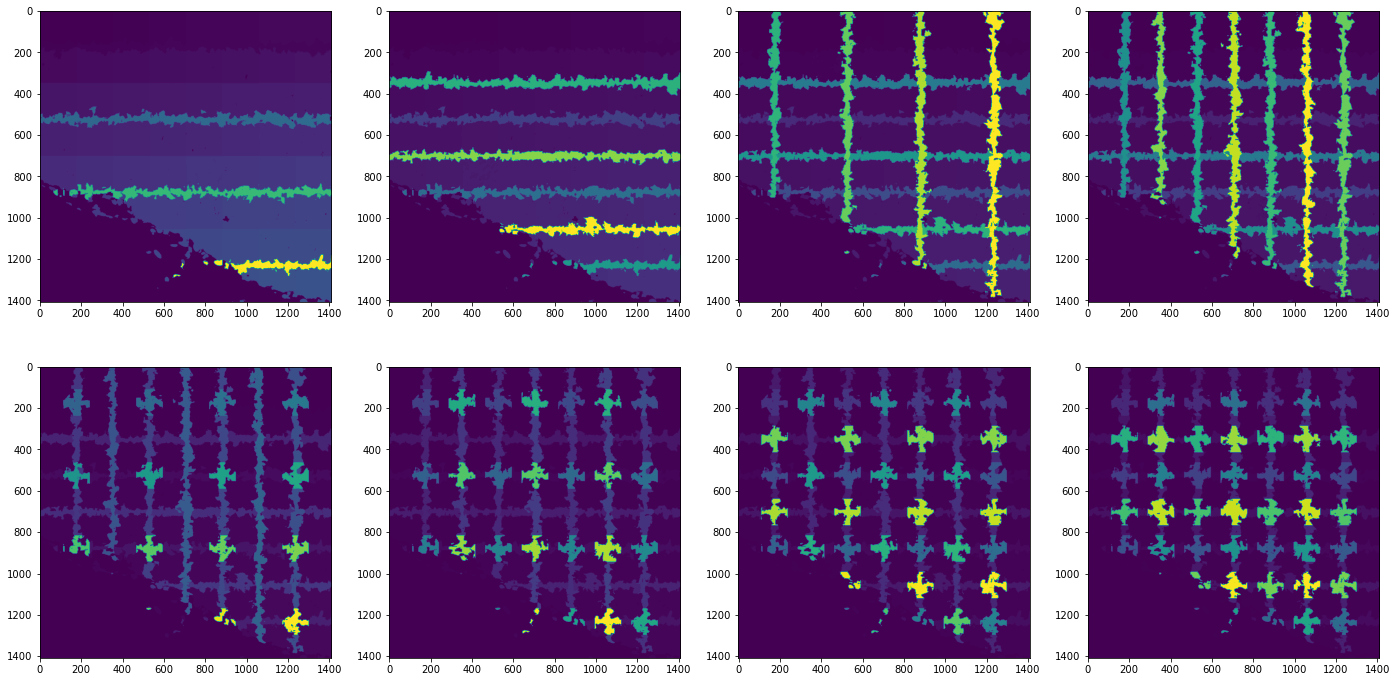

In [31]:
f, axs = plt.subplots(2, 4, figsize=(24, 12))
for img, ax in zip(imgs, axs.flat):
    ax.imshow(img)
plt.show()


Newly processed zip-lines are assigned high labels indicated in yellow of the viridis colormap, nicely demonstrating the zipping process.

<!---The zip-lines still have seams in the places where they intersect. Next we process zip-quads, in which the segments on these intersections are resegmented to finish the zip.-->

Now, we compare the labels before and after the zip:

In [32]:
ids = 'segm/labels_zip'
merg3r.volumes = [{ids: volumes[ids]}]
merg3r._init_paths_merger()
labels_zipped = shuffle_labels(merge_and_slice_dset(merg3r, ids))


2021-06-03 13:09:55 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:09:55 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running merger:blockinfo
Running merger:merge


2021-06-03 13:10:11 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:10:11 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess


<ipython-input-33-73d41aa77055>:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  ax.imshow(label2rgb(shuffle_labels(img)))


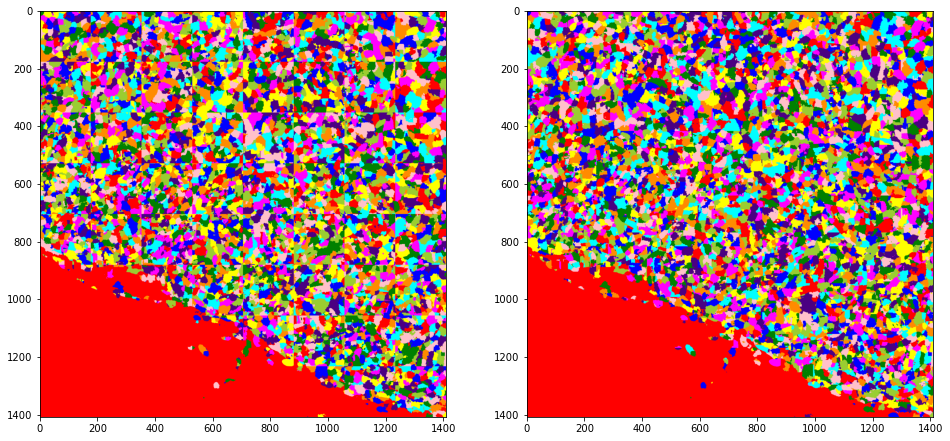

In [33]:
f, axs = plt.subplots(1, 2, figsize=(16, 32))
for img, ax in zip([labels, labels_zipped], axs.flat):
    ax.imshow(label2rgb(shuffle_labels(img)))
plt.show()


View the zip result with napari:

In [34]:
idss = ['segm/labels', 'segm/labels_zip']

merg3r = blocks.Merg3r(image_in, parameter_file, prefix=dataset)
merg3r.volumes = [{ids: volumes[ids]} for ids in idss]
merg3r._init_paths_merger()
merg3r.run()

viewer_settings = {
    'title': 'STAPL3D merg3r demo',
    'crosshairs': [int(merg3r.blocksize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clims': [0, 1],
    'opacity': 1,
}

filepath = merg3r.outputpaths['postprocess']['aggregate']
merg3r.view(input=filepath, images=[], labels=idss, settings=viewer_settings)

# NOTE: some new seams are created on the margins because the blocks of this demo are too small


2021-06-03 13:10:14 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:10:14 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running merger:blockinfo
Running merger:merge


2021-06-03 13:10:28 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:10:28 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels: HFK16w_segm-labels.h5
        segm/labels_zip: HFK16w_segm-labels_zip.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess


## Compartmental segmentation

In STAPL-3D, we use rich multidimensional data to obtain a robust segmentation. We can also use the information we have to perform subcellular segmentation. Here, we split segments in nucleus and membrane subsegments such that we can specifically extract intensities from the appropriate voxels for the type of staining (nuclear or membranal). In addition, the subsegmentation opens up possibilities for defining compound features that inform on internal cell structure.


In [35]:
from stapl3d.segmentation import segment

subsegment3r = segment.Subsegment3r(image_in, parameter_file, prefix=dataset)
subsegment3r.run()


2021-06-03 13:10:33 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:10:33 [MainThread  ] [INFO ]  Parameters: 
subsegmentation:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: subsegmentation
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running subsegmentation:blockinfo
Running subsegmentation:estimate


In [36]:
vols = [f'segm/labels_{vol}' for vol in ['full', 'nucl', 'memb']]
merg3r = blocks.Merg3r(image_in, parameter_file, prefix=dataset)
merg3r.volumes = [{vol: {'format': 'h5', 'suffix': None, 'is_labelimage': True}} for vol in vols]
merg3r._init_paths_merger()
merg3r.run()

viewer_settings = {
    'title': 'STAPL3D merg3r demo',
    'crosshairs': [int(merg3r.blocksize[dim] / 2) for dim in 'zyx'],
    'axes_visible': False,
    'clims': [0, 1],
    'opacity': 1,
}

filepath = merg3r.outputpaths['postprocess']['aggregate']
merg3r.view(input=filepath, images=[], labels=vols, settings=viewer_settings)


2021-06-03 13:11:50 [MainThread  ] [INFO ]  Running step "blockinfo" over 64 jobs using 16 workers
2021-06-03 13:11:50 [MainThread  ] [INFO ]  Parameters: 
merger:
  blockinfo:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        data: HFK16w_shading_stitching.ims
      outputs:
        blockfiles: blocks/HFK16w_blocks_B{b:05d}.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params:
      blockmargin:
        c: 0
        t: 0
        x: 64
        y: 64
        z: 0
      blocksize:
        c: 8
        t: 1
        x: 176
        y: 176
        z: 106
      fullsize:
        c: 8
        t: 1
        x: 1408
        y: 1408
        z: 106
    submit:
      _n_workers: 16
      blocks:
      - 0
      - 1
      - 2
      - 3
      - 4
      - 5
      - 6
      - 7
      - 8
      - 9
      - 10
      - 11
      - 12
      - 13
      - 14
      - 15
      - 16
  

Parameter file specified inputs for step "blockinfo":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Parameter file specified inputs for step "merge":
   ... using {'data': 'HFK16w_shading_stitching.ims'}.
Running merger:blockinfo
Running merger:merge


2021-06-03 13:12:20 [MainThread  ] [INFO ]  Running step "postprocess" over 1 jobs using 1 workers
2021-06-03 13:12:20 [MainThread  ] [INFO ]  Parameters: 
merger:
  postprocess:
    files:
      datadir: /Users/michielkleinnijenhuis/demos_clean/HFK16w
      directory: merger
      image_in: HFK16w_shading_stitching.ims
      inputs:
        segm/labels_full: HFK16w_segm-labels_full.h5
        segm/labels_memb: HFK16w_segm-labels_memb.h5
        segm/labels_nucl: HFK16w_segm-labels_nucl.h5
      outputs:
        aggregate: merger/merged.h5
      parameter_file: HFK16w.yml
      prefix: HFK16w
    params: {}
    submit:
      _n_workers: 1



Running merger:postprocess
